In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/khairul-amin-cyber/CSE499-MerakiNexus-AI_And_Defi.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Cloning into 'CSE499-MerakiNexus-AI_And_Defi'...
remote: Enumerating objects: 5261, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 5261 (delta 35), reused 21 (delta 21), pack-reused 5207 (from 2)
Receiving objects: 100% (5261/5261), 1.61 GiB | 17.02 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Updating files: 100% (6368/6368), done.


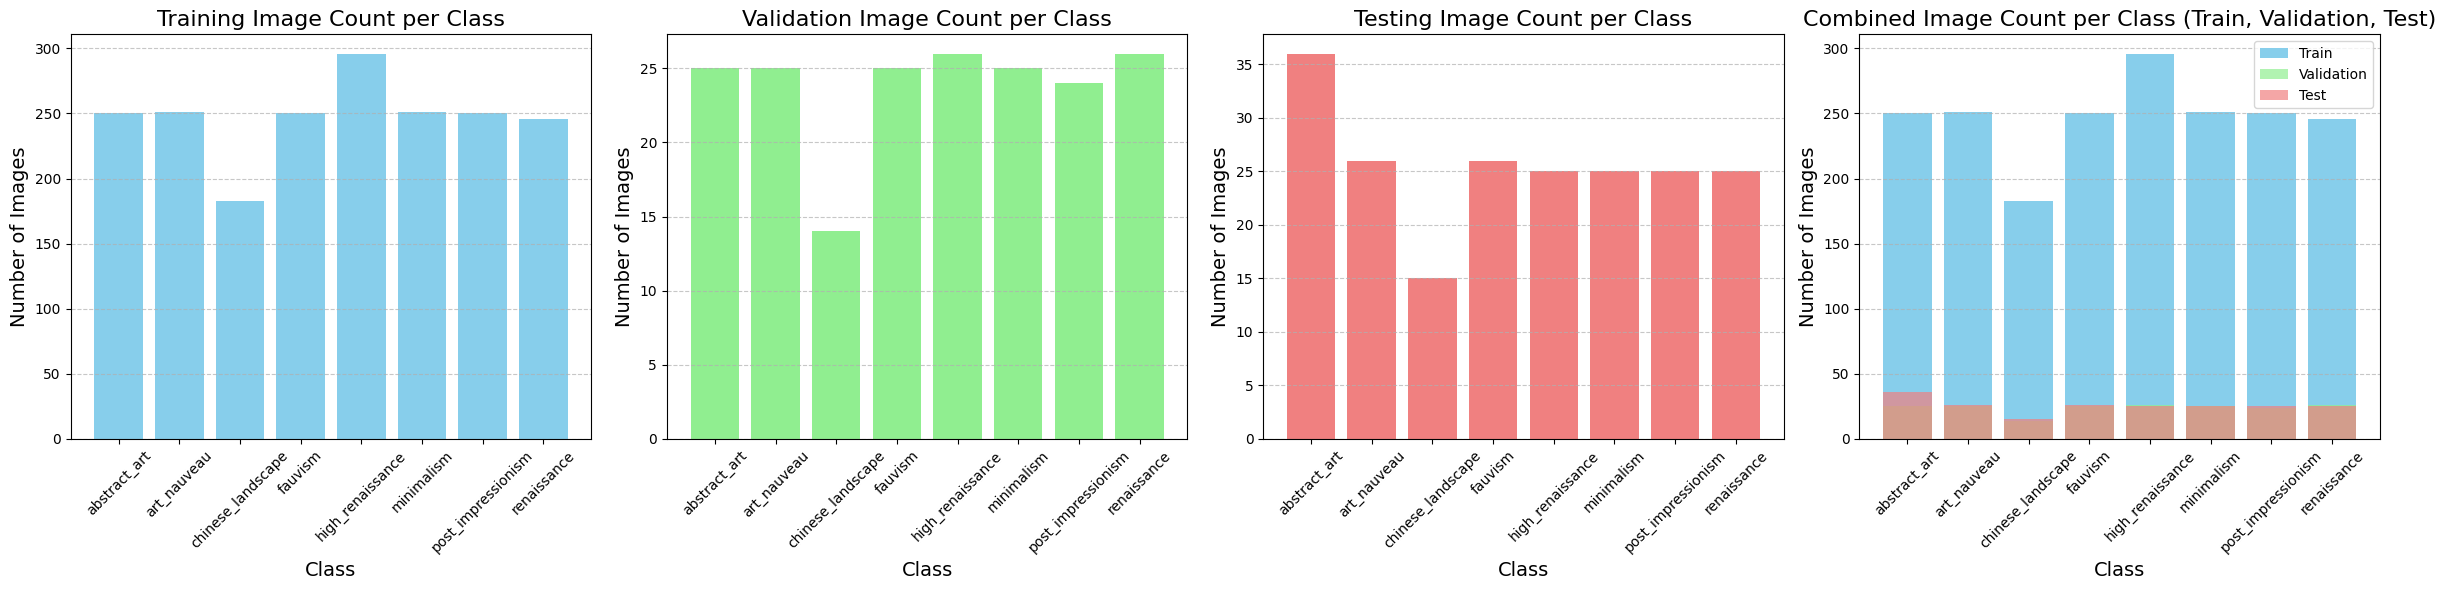

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/aesthetic_model/aesthetic_dataset"  # Modify with your dataset path

# Load the datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and their corresponding folder paths
class_names = train_dataset.classes
train_image_counts = []
val_image_counts = []
test_image_counts = []

# Count the number of images in each class folder for all datasets
for class_name in class_names:
    # Count for training set
    train_class_folder = os.path.join(train_dataset.root, class_name)
    train_image_count = len(os.listdir(train_class_folder))  # Count files in each class folder
    train_image_counts.append(train_image_count)

    # Count for validation set
    val_class_folder = os.path.join(val_dataset.root, class_name)
    val_image_count = len(os.listdir(val_class_folder))  # Count files in each class folder
    val_image_counts.append(val_image_count)

    # Count for testing set
    test_class_folder = os.path.join(test_dataset.root, class_name)
    test_image_count = len(os.listdir(test_class_folder))  # Count files in each class folder
    test_image_counts.append(test_image_count)

# Plotting the class distribution for training, validation, and testing sets side by side
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot for training dataset
axes[0].bar(class_names, train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
axes[0].set_xlabel('Class', fontsize=14)
axes[0].set_ylabel('Number of Images', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for validation dataset
axes[1].bar(class_names, val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
axes[1].set_xlabel('Class', fontsize=14)
axes[1].set_ylabel('Number of Images', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for testing dataset
axes[2].bar(class_names, test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
axes[2].set_xlabel('Class', fontsize=14)
axes[2].set_ylabel('Number of Images', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for combined view (Training, Validation, and Testing)
axes[3].bar(class_names, train_image_counts, color='skyblue', label='Train')
axes[3].bar(class_names, val_image_counts, color='lightgreen', label='Validation', alpha=0.7)
axes[3].bar(class_names, test_image_counts, color='lightcoral', label='Test', alpha=0.7)
axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xlabel('Class', fontsize=14)
axes[3].set_ylabel('Number of Images', fontsize=14)
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


In [4]:
# Mapping of sub-classes to main aesthetic classes (binary labels for each class)
class_to_main_class = {
    "abstract_art": [1, 0, 0, 0],  # Balance
    "art_nauveau": [1, 0, 0, 0],   # Balance
    "chinese_landscape": [0, 0, 0, 1],  # Texture & Brushwork
    "fauvism": [0, 1, 0, 0],  # Color Harmony
    "high_renaissance": [0, 0, 1, 0],  # Depth & Perspective
    "minimalism": [0, 0, 0, 1],  # Texture & Brushwork
    "post_impressionism": [0, 0, 1, 0],  # Depth & Perspective
    "renaissance": [0, 1, 0, 0]  # Color Harmony
}

# Custom Dataset to handle multi-label classification
class CustomAestheticDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super().__init__(root_dir, transform=transform)
        self.class_to_main_class = class_to_main_class

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.class_to_main_class[self.classes[class_idx]], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset_path = "/content/CSE499-MerakiNexus-AI_And_Defi/aesthetic_model/aesthetic_dataset"  # Modify with your dataset path

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = CustomAestheticDataset(root_dir=f"{dataset_path}/train", transform=transform)
val_data = CustomAestheticDataset(root_dir=f"{dataset_path}/val", transform=transform)
test_data = CustomAestheticDataset(root_dir=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [5]:
# Define model based on ResNet50 with custom heads for the 4 aesthetic classes
class AestheticModelWithResNet50(nn.Module):
    def __init__(self, num_classes=4):
        super(AestheticModelWithResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Get the in_features from ResNet50's final fully connected layer
        in_features = self.resnet.fc.in_features

        # Remove the final fully connected layer (so that we can add custom heads)
        self.resnet.fc = nn.Identity()

        # Custom heads for the 4 aesthetic classes
        self.balance_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Balance class
        )

        self.color_harmony_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Color Harmony class
        )

        self.depth_perspective_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Depth & Perspective class
        )

        self.texture_brushwork_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output for Texture & Brushwork class
        )

    def forward(self, x):
        features = self.resnet(x)
        balance = self.balance_head(features)
        color_harmony = self.color_harmony_head(features)
        depth_perspective = self.depth_perspective_head(features)
        texture_brushwork = self.texture_brushwork_head(features)

        return balance, color_harmony, depth_perspective, texture_brushwork

# Initialize model, loss function, and optimizer
resNet50_model = AestheticModelWithResNet50(num_classes=4).to(device)
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = optim.Adam(resNet50_model.parameters(), lr=1e-4)

# Training loop with progress bar and time tracking
num_epochs = 3
start_time = time.time()  # Start time for total training

for epoch in range(num_epochs):
    resNet50_model.train()
    running_loss = 0.0
    epoch_start_time = time.time()  # Start time for this epoch

    # Initialize tqdm progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Calculate loss for each output (balance, color harmony, etc.)
            loss_balance = criterion(balance.squeeze(), labels[:, 0])
            loss_color_harmony = criterion(color_harmony.squeeze(), labels[:, 1])
            loss_depth_perspective = criterion(depth_perspective.squeeze(), labels[:, 2])
            loss_texture_brushwork = criterion(texture_brushwork.squeeze(), labels[:, 3])

            # Total loss is the sum of all losses
            total_loss = loss_balance + loss_color_harmony + loss_depth_perspective + loss_texture_brushwork
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            # Update the progress bar with loss information
            tepoch.set_postfix(loss=total_loss.item())

    epoch_end_time = time.time()  # End time for this epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")
    print(f"Epoch Loss: {running_loss / len(train_loader)}")

    # Validation accuracy calculation after each epoch
    resNet50_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

            # Convert logits to probabilities (using sigmoid)
            predictions_balance = torch.sigmoid(balance)
            predictions_color_harmony = torch.sigmoid(color_harmony)
            predictions_depth_perspective = torch.sigmoid(depth_perspective)
            predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

            # Compare predictions to actual labels
            predicted_labels_balance = (predictions_balance > 0.5).float()
            predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
            predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
            predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

            correct += (predicted_labels_balance == labels[:, 0].unsqueeze(1)).sum().item()
            correct += (predicted_labels_color_harmony == labels[:, 1].unsqueeze(1)).sum().item()
            correct += (predicted_labels_depth_perspective == labels[:, 2].unsqueeze(1)).sum().item()
            correct += (predicted_labels_texture_brushwork == labels[:, 3].unsqueeze(1)).sum().item()
            total += labels.size(0) * 4  # Total labels for all 4 categories

    val_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} Validation Accuracy: {val_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]
Epoch 1/3 Training: 100%|██████████| 62/62 [00:40<00:00,  1.51batch/s, loss=1.17]


Epoch 1/3 completed in 40.96 seconds.
Epoch Loss: 1.4320345876678344


Epoch 1/3 Validation Accuracy: 85.85%


Epoch 2/3 Training: 100%|██████████| 62/62 [00:39<00:00,  1.58batch/s, loss=0.52]


Epoch 2/3 completed in 39.28 seconds.
Epoch Loss: 0.5375412154582239


Epoch 2/3 Validation Accuracy: 85.98%


Epoch 3/3 Training: 100%|██████████| 62/62 [00:39<00:00,  1.55batch/s, loss=0.07]


Epoch 3/3 completed in 39.94 seconds.
Epoch Loss: 0.2393679063647024


Epoch 3/3 Validation Accuracy: 85.19%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


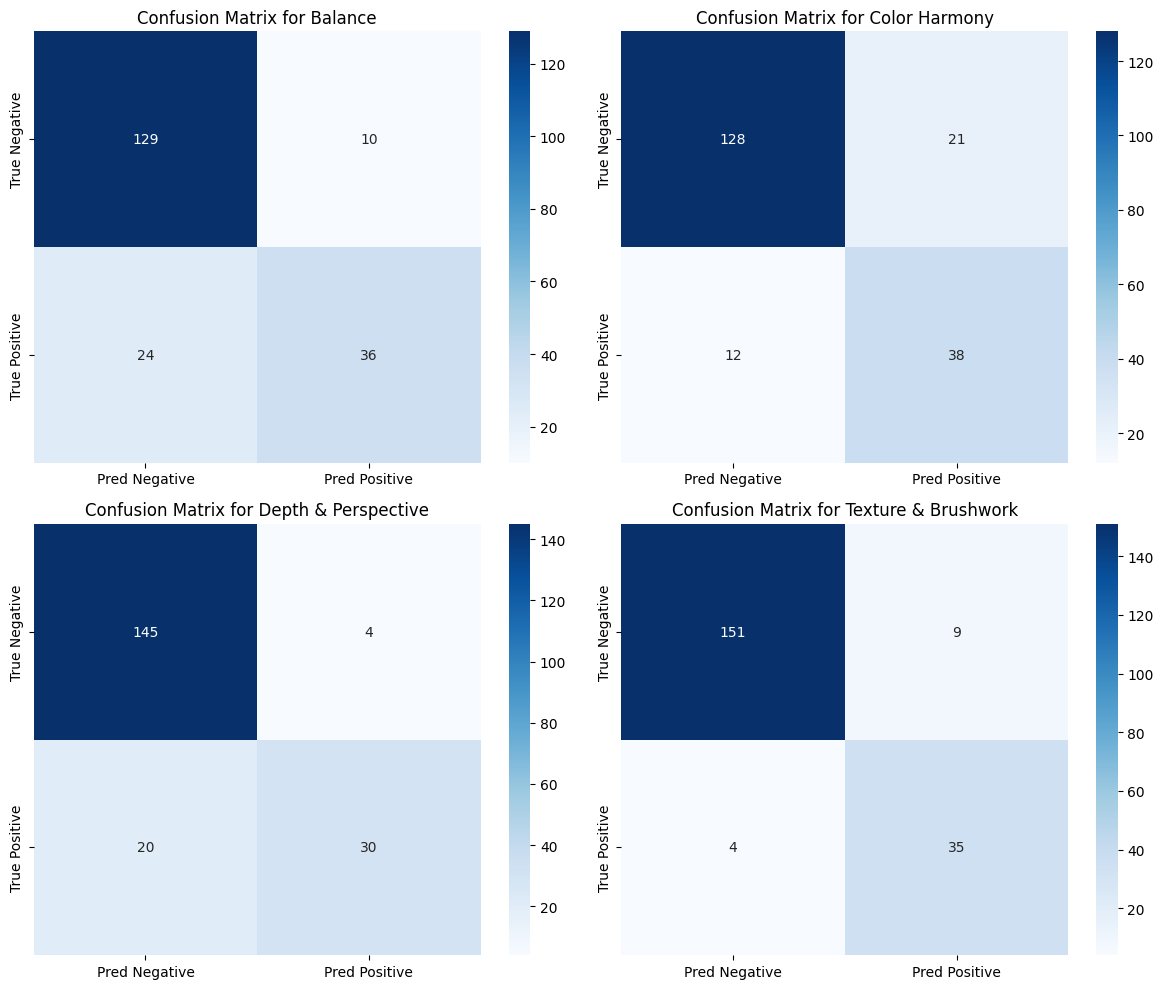

Test Accuracy: 86.93%
Precision: 69.60%
Recall: 69.85%
F1-Score: 69.68%


In [6]:
# Define aesthetic categories
aesthetic_categories = ["Balance", "Color Harmony", "Depth & Perspective", "Texture & Brushwork"]

# Set the model to evaluation mode
resNet50_model.eval()

# Initialize variables to hold predictions and ground truths
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        balance, color_harmony, depth_perspective, texture_brushwork = resNet50_model(images)

        # Convert logits to probabilities using sigmoid
        predictions_balance = torch.sigmoid(balance)
        predictions_color_harmony = torch.sigmoid(color_harmony)
        predictions_depth_perspective = torch.sigmoid(depth_perspective)
        predictions_texture_brushwork = torch.sigmoid(texture_brushwork)

        # Binarize predictions (thresholding at 0.5)
        predicted_labels_balance = (predictions_balance > 0.5).float()
        predicted_labels_color_harmony = (predictions_color_harmony > 0.5).float()
        predicted_labels_depth_perspective = (predictions_depth_perspective > 0.5).float()
        predicted_labels_texture_brushwork = (predictions_texture_brushwork > 0.5).float()

        # Concatenate the predictions for all categories (multi-label classification)
        all_predictions.append(torch.cat((predicted_labels_balance, predicted_labels_color_harmony,
                                          predicted_labels_depth_perspective, predicted_labels_texture_brushwork), dim=1))
        all_labels.append(labels)

# Convert the lists to tensors
all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Calculate accuracy
accuracy = (all_predictions == all_labels).sum() / all_labels.size

# Calculate Precision, Recall, and F1-Score (using 'samples' average for multi-label)
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')

# Generate Multi-label Confusion Matrix (for each class)
mcm = multilabel_confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'],
                yticklabels=['True Negative', 'True Positive'], ax=ax)
    ax.set_title(f'Confusion Matrix for {aesthetic_categories[i]}')

plt.tight_layout()
plt.show()

# Display the evaluation metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
